In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import math
import seaborn as sns
from matplotlib import rc
import matplotlib.ticker as ticker
from dataclasses import dataclass
from scipy.stats import norm
from scipy import stats
import pypfopt as ppo

%matplotlib inline

# Setting the Context
## Probabilistic DCF valuation

To calculate the Free Cash Flow to Firm we use the below equation:

<img src="https://latex.codecogs.com/gif.download?%5Cinline%20FCFF%20%5C%3B%20%3D%20%5C%3B%20EBIT%20*%20%281-%20Effective%20Tax%29%20%5C%3B+%5C%3B%20Dep.%5C%3B%20and%20%5C%3B%20Amort.%5C%3B%20-%20%5C%3BChange%5C%3Bin%5C%3BNet%5C%3BWorking%5C%3BCapital-%5C%3BCAPEX">

To forecast the FCFF we need to forecast each element in the above equiation, and for do it automatically we need to introduce proxies for each item:

<img src="https://latex.codecogs.com/gif.latex?Reinvestment\;Rate&space;=&space;\;&space;\frac{CapEx\;-\;&space;Dep.\;and\;Amort.\;&plus;\;Changes&space;\;in\;WC}{EBIT\;&space;\times\;&space;(1\;&space;-\;&space;Eff.\;&space;Tax\;&space;Rate)}" title="Reinvestment\;Rate = \; \frac{CapEx\;-\; Dep.\;and\;Amort.\;+\;Changes \;in\;WC}{EBIT\; \times\; (1\; -\; Eff.\; Tax\; Rate)}" />


<img src="https://latex.codecogs.com/gif.latex?Return\;on\;Capital&space;=&space;\frac{EBIT\;&space;\times\;&space;(1\;&space;-\;&space;Eff.\;&space;Tax\;&space;Rate)}{Total\;Debt\;&plus;\;Total\;Equity}" title="Return\;on\;Capital = \frac{EBIT\; \times\; (1\; -\; Eff.\; Tax\; Rate)}{Total\;Debt\;+\;Total\;Equity}" />

and the internal growth rate will be : 

<img src="https://latex.codecogs.com/gif.latex?g\;=\;&space;Reinvestment\;Rate\;&space;\times\;&space;ROC" title="g\;=\; Reinvestment\;Rate\; \times\; ROC" />

first we need to extract the historical data for each proxy and we will assume that the future rates will oscillate around the historical mean and standard deviation. 


### Resources
https://www.youtube.com/watch?v=8gYT3Xgs6NE \
https://pages.stern.nyu.edu/~adamodar/ \
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3237778


# Loading Data

In [2]:
path = 'C:\\Users\\nemat\\Desktop\\Master Folder\\Buffet in the box contd\\auto_examples_jupyter\\Nomad Foods Limited NYSE NOMD Financials.xls'
tickers = ['NOMD']
WACC = 0.065894

inc_df = pd.read_excel(path,
                      sheet_name='Income Statement', skiprows=14, index_col=0)
bs_df = pd.read_excel(path,
                         sheet_name='Balance Sheet', skiprows=14,index_col=0)
cf_df = pd.read_excel(path,
                         sheet_name='Cash Flow', skiprows=14,index_col=0)
Mult_df = pd.read_excel(path,
                         sheet_name='Multiples', skiprows=13,index_col=0)


WARNING *** file size (273418) not 512 + multiple of sector size (512)
WARNING *** file size (273418) not 512 + multiple of sector size (512)
WARNING *** file size (273418) not 512 + multiple of sector size (512)
WARNING *** file size (273418) not 512 + multiple of sector size (512)


# Data cleaning and calculation functions 

In [3]:
def StatementParser(df):
    date={}
    for i in range(len(df.columns)):
        if type(df.columns[i]) is str:
            match = re.search(r'\w{3}-\d{2}-\d{4}', str(df.columns[i]))
            date[str(df.columns[i])] = datetime.datetime.strptime(match.group(), '%b-%d-%Y').date()
        else:
            match = re.search(r'\d{4}-\d{2}-\d{2}', str(df.columns[i]))
            date[str(df.columns[i])] = datetime.datetime.strptime(match.group(), '%Y-%m-%d').date()
    df.rename(columns = date, inplace = True)
    df.replace(to_replace='-', value= 0 , inplace=True)
    df.dropna(how = 'all', inplace = True)
    df.drop('Currency', inplace = True)
    
    df = df.T
    df['Date'] = df.index
    df.set_index(df['Date'], inplace = True)
    df.drop('Date', axis=1, inplace = True)
    
    col={}
    for i in range(len(df.columns)):
        col[str(df.columns[i])] = str(str(df.columns[i]).lstrip())
    df.rename(columns = col, inplace = True)
    
    if df.index[-1].month != df.index[0].month:
        df.drop(df.tail(1).index , inplace=True)
    else:
        pass

    return df

def multiplesParser(df):
    a = df.loc[df.index == 'TEV/NTM EBIT'].T
    b = df.loc[df.index == 'TEV/LTM EBIT'].T
    c = df.loc[df.index == 'TEV/NTM EBITDA'].T
    d = df.loc[df.index == 'TEV/LTM EBITDA'].T
    mult = a.join(b.join(c.join(d))).T
    mult.drop(columns=mult.columns[0], inplace = True)
    mult.replace(to_replace = '-', value = np.nan, inplace = True)
    mult.replace(to_replace = 'NM', value = np.nan, inplace = True)    
    mult = mult.apply(pd.to_numeric)
    mult = mult.T
    return mult
    
def load_info(tickers):
    inf = [[0 for i in range(len(tickers))] for j in range(8)]
    for i in range(len(tickers)):
        info = yf.Ticker(tickers[i]).info
        inf[0][i] = info['longName']
        inf[1][i] = info['sector']
        inf[2][i] = info['marketCap']
        inf[3][i] = info['beta']
        inf[4][i] = info['returnOnAssets']
        inf[5][i] = info['returnOnEquity']
        inf[6][i] = info['enterpriseToRevenue']
        inf[7][i] = info['enterpriseToEbitda']
    inf_df = pd.DataFrame(data = [inf[0], inf[1], np.array(inf[2])/1000000000, inf[3], inf[4], inf[5], inf[6], inf[7]],
                         index = ['Name', 'Sector', 'Market Cap $B', 'Beta', 'ROA', 'ROE', 'EV/Revenue', 'EV/EBITDA'],
                         columns = tickers).T
    return inf, inf_df

## Loading Multiples

In [4]:
multiples = multiplesParser(Mult_df)

In [5]:
IS = StatementParser(inc_df)

In [6]:
BS = StatementParser(bs_df)

In [7]:
CF = StatementParser(cf_df)

In [8]:
info, info_df = load_info(tickers)
info_df

,Name,Sector,Market Cap $B,Beta,ROA,ROE,EV/Revenue,EV/EBITDA
NOMD,Nomad Foods Limited,Consumer Defensive,4.290804,0.590129,0.04408,0.09318,2.542,14.159


In [9]:
today = datetime.date.today().strftime('%Y-%m-%d')
market_data = yf.download(tickers, start = '2000-01-01' , end = today, interval = '1d')

[*********************100%***********************]  1 of 1 completed


# Looking at the Capital Structure

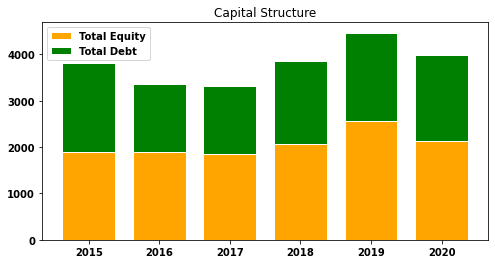

In [10]:
plt.figure(figsize=(8,4))
rc('font', weight = 'bold')
bars2 = BS['Total Debt']
bars1 = BS['Total Equity']

bars = np.add(bars1, bars2).tolist()

r = range(len(bars1))
 
names = BS.index.year
barWidth = 0.75

plt.bar(r, bars1, color='orange', edgecolor='white', width=barWidth, label = 'Total Equity')
plt.bar(r, bars2, bottom=bars1, color='green', edgecolor='white', width=barWidth, label = 'Total Debt')

plt.xticks(r, names, fontweight='bold')
plt.title("Capital Structure")
plt.legend()
plt.show()

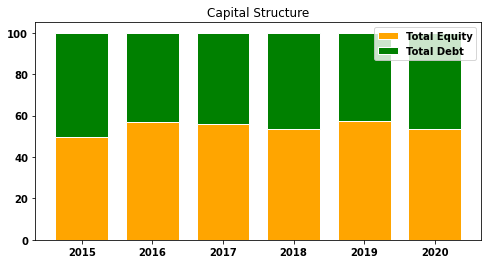

In [11]:
plt.figure(figsize=(8,4))
# Data
# r = []
raw_data = {'greenBars': BS['Total Debt'], 'orangeBars': BS['Total Equity']}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
 
# plot
barWidth = 0.75
# names = ()
# Create orange Bars (Equity)
plt.bar(r, orangeBars, color='orange', edgecolor='white', width=barWidth, label = 'Total Equity')
# Create green Bars (Debt)
plt.bar(r, greenBars, bottom=orangeBars, color='green', edgecolor='white', width=barWidth, label = 'Total Debt')
 
# Custom x axis
plt.xticks(r, names)
plt.title('Capital Structure')
 
# Show graphic
plt.legend(loc = 'upper right')
plt.show()


# Calculating the Fundamentals

In [12]:
revenue = IS['Revenue']
Chg_WC = CF['Change in Net Working Capital']
eff_tax = IS['Effective Tax Rate %'].replace('NM' , 0)
capex = abs(CF['Capital Expenditure'])
depreciation = CF['Depreciation & Amort., Total']
EBIT = IS['EBIT']
after_tax_EBIT = EBIT * (1 - eff_tax)
Reinv_rate = (capex - depreciation + Chg_WC) / (EBIT * (1 - eff_tax))
roc = (IS['EBIT'] * (1 - eff_tax)) / (BS['Total Debt'] + BS['Total Equity'])
g = Reinv_rate * roc
fundamentals = pd.DataFrame(data = [revenue, Chg_WC, eff_tax, capex, depreciation, EBIT, after_tax_EBIT,
                                        Reinv_rate, roc, g],
                                index= [ 'Revenue','Change in Working Capital',
                                        'Effective Tax Rate', 'Capex', 'Depr. & Amort.', 'EBIT','EBIT (1-t)',
                                        'Reinvestment Rate', 'ROC', 'g']).T

Terminal_multiple = multiples['TEV/NTM EBIT'].mean()
terminalChanges = 3 * multiples['TEV/NTM EBIT'].std()
vwap_df = market_data[-252:]
vwap = round(np.average(vwap_df['Adj Close'], weights=vwap_df['Volume']),2)

In [13]:
fundamentals

,Revenue,Change in Working Capital,Effective Tax Rate,Capex,Depr. & Amort.,EBIT,EBIT (1-t),Reinvestment Rate,ROC,g
Date,,,,,,,,,,
2015-12-31,894.2,NaN,0.000000,19.3,20.8,127.5,127.500000,NaN,0.033429,NaN
2016-12-31,1927.7,-126.6,0.521052,38.0,51.1,268.5,128.597538,-1.086335,0.038320,-0.041628
2017-12-31,1956.6,39.5,0.189910,42.6,42.4,276.5,223.989885,0.177240,0.067622,0.011985
2018-12-31,2172.8,-40.7,0.249229,41.6,46.3,302.7,227.258382,-0.199773,0.058894,-0.011765
2019-12-31,2324.3,-15.5,0.269614,47.3,63.6,334.2,244.095001,-0.130277,0.054655,-0.007120
2020-12-31,2515.9,-109.1,0.238240,58.7,63.2,381.9,290.916144,-0.390491,0.073001,-0.028506


In [14]:
Terminal_multiple, terminalChanges

(13.621629080000002, 2.393940535295925)

# Running the Simulation

In [15]:
t_intervals = 10
iterations = 1000000

In [16]:
values = []
for i in range(iterations):
    Expected_g = np.random.normal(np.mean(fundamentals['g']), np.std(fundamentals['g']), size = t_intervals)
    simWACC = np.random.normal(WACC, 0.01, size= t_intervals)
    Reinvestment_rate = np.random.normal(np.mean(fundamentals['Reinvestment Rate']), np.std(fundamentals['Reinvestment Rate']), size = t_intervals)
    tax = np.random.normal(np.mean(fundamentals['Effective Tax Rate']), np.std(fundamentals['Effective Tax Rate']), size = t_intervals)
    change_in_working_capital = np.random.normal(np.mean(fundamentals['Change in Working Capital']), np.std(fundamentals['Change in Working Capital']), size = t_intervals)

    TerMulSim = np.random.normal(Terminal_multiple, terminalChanges)

    EBIT_E = []
    a = EBIT[-1]
    for i in range(t_intervals):
        a *= (1 + Expected_g[i])
        EBIT_E.append(a)

    after_tax_EBIT = (EBIT_E * (1 - tax))

    Capex_Dep = (after_tax_EBIT * Reinvestment_rate) - change_in_working_capital

    FCFF = after_tax_EBIT - change_in_working_capital - Capex_Dep

    discount_factor = []
    for i in range(t_intervals):
        if i == 0:
            i = 1 + simWACC[i]
            discount_factor.append(i)
        else:
            i = (1 + simWACC[i]) ** i
            discount_factor.append(i)

    PV = FCFF / discount_factor
    terminalValue = (EBIT_E[-1] * TerMulSim)
    PV_tV = terminalValue / ((1 + WACC) ** t_intervals)
    equityValue = PV.sum() + PV_tV - BS['Net Debt'][-1]
    sharesOutstanding = IS['Weighted Avg. Diluted Shares Out.'][-1]
    v = equityValue / sharesOutstanding
    values.append(v)



In [17]:
stock = round(market_data['Adj Close'][-1], 2)
stock

24.29

<ipython-input-18-f9eed391a0c7>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.histplot(values, color='orange', label = 'Simulations').set_xticklabels(xlabels)


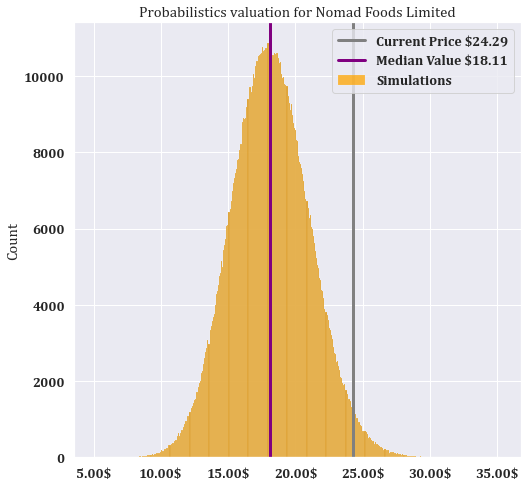

In [18]:
sns.set(rc={'figure.figsize':(8,8)})
sns.set(font_scale = 1.25, font = 'Cambria')
plt.axvline(x=stock, ymin=0,ymax=np.max(values), label = f'Current Price ${stock}', linewidth = 3, color = 'gray')
plt.axvline(x=np.median(values), ymin=0,ymax=np.max(values), label = f'Median Value ${round(np.median(values),2)}',
            linewidth = 3, color = 'purple')

xlabels = ['{:,.2f}'.format(x) + '$' for x in sns.histplot(values).get_xticks()]
sns.histplot(values, color='orange', label = 'Simulations').set_xticklabels(xlabels)
plt.title(label = f"Probabilistics valuation for {info[0][0]}")
plt.legend()
plt.show()

<ipython-input-19-9ce9dff44003>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.ecdfplot(x=values, color = 'orange', label = 'Simulation CDF', linewidth = 4).set_xticklabels(xlabels)


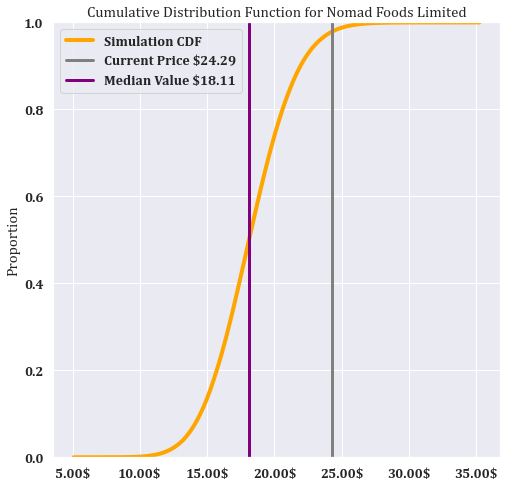

In [19]:
xlabels = ['{:,.2f}'.format(x) + '$' for x in sns.ecdfplot(x=values).get_xticks()]
sns.ecdfplot(x=values, color = 'orange', label = 'Simulation CDF', linewidth = 4).set_xticklabels(xlabels)
plt.axvline(x=stock, ymin=0,ymax=np.max(values), label = f'Current Price ${stock}', linewidth = 3, color = 'gray')
plt.axvline(x=np.median(values), ymin=0,ymax=np.max(values), label = f'Median Value ${round(np.median(values),2)}',
            linewidth = 3, color = 'purple')
plt.title(label = f"Cumulative Distribution Function for {info[0][0]}")

plt.legend()
plt.show()

In [20]:
Percentile_table = pd.DataFrame(data = [np.percentile(values, 0), np.percentile(values, 10), np.percentile(values, 20),
                                       np.percentile(values, 30), np.percentile(values, 40), np.percentile(values, 50),
                                       np.percentile(values, 60), np.percentile(values, 70), np.percentile(values, 80),
                                       np.percentile(values, 90), np.percentile(values, 100)],
                               index = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],
                               columns = ['Values'])

Percentile_table.index.name = 'Percentiles'
Percentile_table

,Values
Percentiles,
0%,5.066419
10%,14.486890
20%,15.704490
30%,16.601765
40%,17.375215
50%,18.106224
60%,18.847221
70%,19.649916
80%,20.599991


In [21]:
valuation = pd.DataFrame(data = [datetime.datetime.now(),np.array(values).mean() - np.array(values).std(), 
                                np.array(values).mean(),
                                np.array(values).mean() + np.array(values).std(),
                                stock, vwap],
                        index = ['time','Worst Case', 'Base Case','Best Case', 'Market Price', 'VWAP'],
                        columns = tickers).T
valuation.index.name = 'Ticker'
valuation.to_csv('valuation.csv', mode = 'a')
valuation.round(2)

,time,Worst Case,Base Case,Best Case,Market Price,VWAP
Ticker,,,,,,
NOMD,2021-11-28 18:38:16.206411,15.258335,18.171317,21.0843,24.29,26.84


In [22]:
valu = pd.DataFrame(data = values, columns = tickers)

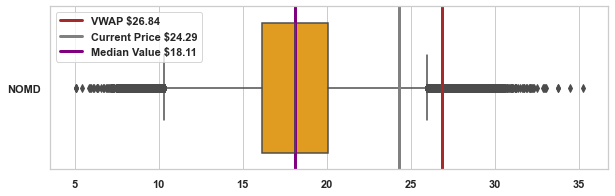

In [23]:
sns.set(rc={'figure.figsize':(10,3)})
sns.set_theme(style = 'whitegrid')
sns.boxplot(data = valu, orient='h', color = 'orange')

plt.axvline(x=vwap, ymin=0,ymax=np.max(values), label = f'VWAP ${vwap}', linewidth = 3, color = 'brown')
plt.axvline(x=stock, ymin=0,ymax=np.max(values), label = f'Current Price ${stock}', linewidth = 3, color = 'gray')
plt.axvline(x=np.median(values), ymin=0,ymax=np.max(values), label = f'Median Value ${round(np.median(values),2)}',
            linewidth = 3, color = 'purple')
plt.legend(loc = 'upper left')

In [24]:
fcf_table = pd.DataFrame(data = [Reinvestment_rate, Expected_g, tax,
                                 EBIT_E, after_tax_EBIT, change_in_working_capital,
                                 Capex_Dep, FCFF, simWACC, discount_factor,PV],
                         index = ['Reinvestment Rate', 'Expected Growth',
                                   'Tax','EBIT','EBIT(1-t)',
                                  'Change in Working Capital', 'Capex - Depreciation',
                                  'FCFF', 'WACC','Discount Factor','PV']).T
fcf_table

,Reinvestment Rate,Expected Growth,Tax,EBIT,EBIT(1-t),Change in Working Capital,Capex - Depreciation,FCFF,WACC,Discount Factor,PV
0,-0.178439,-0.018282,0.144026,374.918116,320.920226,2.836523,-60.101300,378.185003,0.067829,1.067829,354.162645
1,-0.366160,-0.024382,0.276596,365.777018,264.604615,46.445048,-143.332778,361.492345,0.055516,1.055516,342.479128
2,-0.026481,-0.016711,0.125424,359.664691,314.553965,-9.832757,1.503107,322.883615,0.058289,1.119975,288.295402
3,-0.270822,0.006120,0.320967,361.865959,245.719020,7.793245,-74.339437,312.265212,0.056858,1.180456,264.529237
4,-0.146668,-0.008025,0.290731,358.962149,254.600643,-118.185428,80.843648,291.942423,0.065909,1.290866,226.160187
5,-0.635990,0.008495,0.161871,362.011654,303.412608,-132.060718,-60.906768,496.380093,0.075752,1.440657,344.551159
6,-0.097303,-0.017434,0.636687,355.700338,129.230654,-95.513836,82.939342,141.805148,0.052561,1.359827,104.281727
7,-0.914975,-0.018879,0.076682,348.984975,322.223995,-113.412141,-181.414920,617.051055,0.050032,1.407399,438.433586
8,-0.000902,-0.033890,0.045779,337.158005,321.723410,41.210941,-41.500994,322.013463,0.073639,1.765493,182.392951
9,-0.651524,0.016096,0.553562,342.584982,152.942961,-15.022564,-84.623407,252.588932,0.070365,1.844118,136.970014


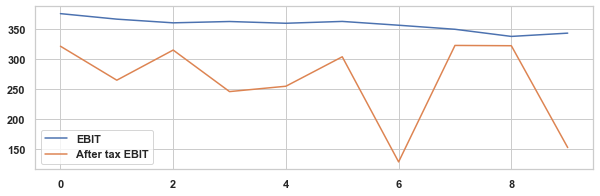

In [25]:
plt.plot(EBIT_E,label = 'EBIT')
plt.plot(after_tax_EBIT, label = 'After tax EBIT')
plt.legend()

In [26]:
s = market_data['Adj Close']
returns = ppo.expected_returns.mean_historical_return(s.values)
stdev = ppo.risk_models.risk_matrix(s, method='sample_cov')
# np.std(s.pct_change())
stats = pd.DataFrame(data = [returns.values[0], stdev.values[0][0]],
             index = ['Mean', 'StDev'], columns = tickers)
stats


C:\Users\nemat\AppData\Roaming\Python\Python38\site-packages\pypfopt\expected_returns.py:119: RuntimeWarning: prices are not in a dataframe
  warnings.warn("prices are not in a dataframe", RuntimeWarning)
C:\Users\nemat\AppData\Roaming\Python\Python38\site-packages\pypfopt\risk_models.py:165: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)


,NOMD
Mean,0.135867
StDev,0.117368


Text(0, 0.5, 'Cumulative Returns')

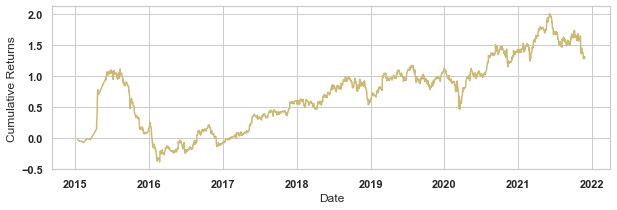

In [27]:
plt.plot((1 + s.pct_change()).cumprod() - 1, color = 'y')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

Text(0, 0.5, 'Close Price')

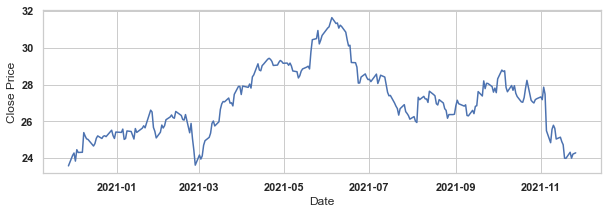

In [28]:
plt.plot(market_data['Close'][-(252):])
plt.xlabel('Date')
plt.ylabel('Close Price')